In [1]:
%matplotlib inline



Computing a covariance matrix
=============================


Many methods in MNE, including source estimation and some classification
algorithms, require covariance estimations from the recordings.
In this tutorial we cover the basics of sensor covariance computations and
construct a noise covariance matrix that can be used when computing the
minimum-norm inverse solution.

In [2]:
import os.path as op

import mne
from mne.datasets import sample

Let's read in the raw data

In [3]:
data_path = sample.data_path()
raw_fname = op.join(data_path, 'MEG', 'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference('average', projection=True)
raw.info['bads'] += ['EEG 053']  # bads + 1 more

Opening raw data file /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated


... and then the empty room data

In [4]:
raw_empty_room_fname = op.join(
    data_path, 'MEG', 'sample', 'ernoise_raw.fif')
raw_empty_room = mne.io.read_raw_fif(raw_empty_room_fname)

Opening raw data file /Users/mainak/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.


Warning: processing pipeline for noise covariance calculation must match actual data!

- Filtering
- ICA, SSP

In [5]:
raw_empty_room.info['bads'] = [
    bb for bb in raw.info['bads'] if 'EEG' not in bb]
raw_empty_room.add_proj(
    [pp.copy() for pp in raw.info['projs'] if 'EEG' not in pp['desc']])

3 projection items deactivated


<Raw | ernoise_raw.fif, 315 x 66068 (110.0 s), ~368 kB, data not loaded>

# What is noise?

- empty room measurement
- resting state (e.g., in the case of evoked)

tmin and tmax for delimiting part of recording as noise

Using empty room measurement

In [6]:
noise_cov = mne.compute_raw_covariance(
    raw_empty_room, tmin=0, tmax=None)

Using up to 550 segments
Number of samples used : 66000
[done]


Now that you have the covariance matrix in an MNE-Python object you can
save it to a file with `mne.write_cov`. Later you can read it back
using `mne.read_cov`.

Using resting state measurement

In [7]:
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, event_id=1, tmin=-0.2, tmax=0.5,
                    baseline=(-0.2, 0.0), decim=3,  # we'll decimate for speed
                    verbose='error')  # and ignore the warning about aliasing

320 events found
Event IDs: [ 1  2  3  4  5 32]


We use baseline correction so that noise is zero mean.

In [8]:
noise_cov_baseline = mne.compute_covariance(epochs, tmax=0)

Loading data for 72 events and 421 original time points (prior to decimation) ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 305 dim * 5.4e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.8e-11 (2.2e-16 eps * 59 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 2952
[done]


Note that this method also attenuates any activity in your
source estimates that resemble the baseline, if you like it or not.



Plot the covariance matrices
----------------------------

Try setting proj to False to see the effect. Notice that the projectors in
epochs are already applied, so ``proj`` parameter has no effect.



    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-15 (2.2e-16 eps * 102 dim * 0.052  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


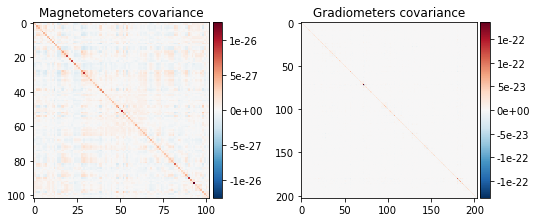

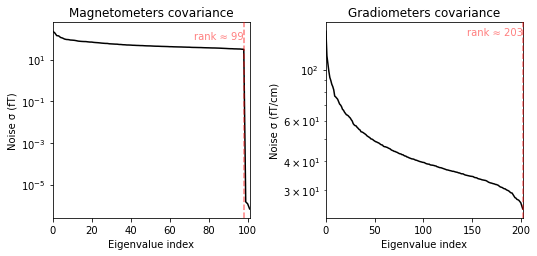

In [9]:
noise_cov.plot(raw_empty_room.info, proj=True);

    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.96  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 203 dim * 4.1  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 59 dim * 6.4  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors


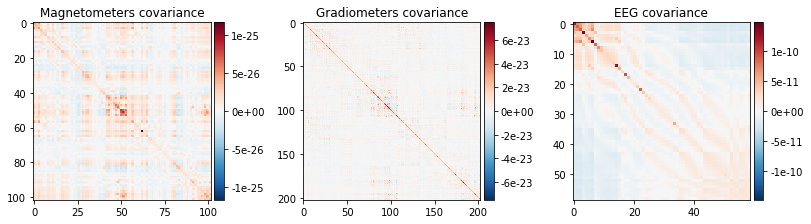

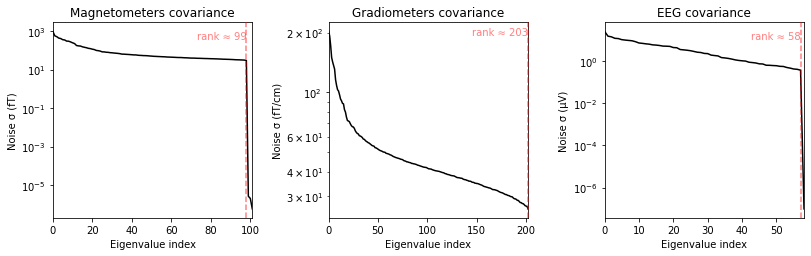

In [10]:
noise_cov_baseline.plot(epochs.info, proj=True);

How should I regularize the covariance matrix?
----------------------------------------------

The estimated covariance can be numerically
unstable and tends to induce correlations between estimated source amplitudes
and the number of samples available.



In MNE-Python, regularization is done using advanced regularization methods
described in [1]. For this the 'auto' option can be used. With this
option cross-validation will be used to learn the optimal regularization:

In [11]:
noise_cov_reg = mne.compute_covariance(epochs, tmax=0., method='auto',
                                       rank=None)

Loading data for 72 events and 421 original time points (prior to decimation) ...
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 305 dim * 5.4e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.8e-11 (2.2e-16 eps * 59 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    GRAD reg

This procedure evaluates the noise covariance quantitatively by how well it
whitens the data using the
negative log-likelihood of unseen data. The final result can also be visually
inspected.
Under the assumption that the baseline does not contain a systematic signal
(time-locked to the event of interest), the whitened baseline signal should
be follow a multivariate Gaussian distribution, i.e.,
whitened baseline signals should be between -1.96 and 1.96 at a given time
sample.
Based on the same reasoning, the expected value for the global field power
(GFP) is 1



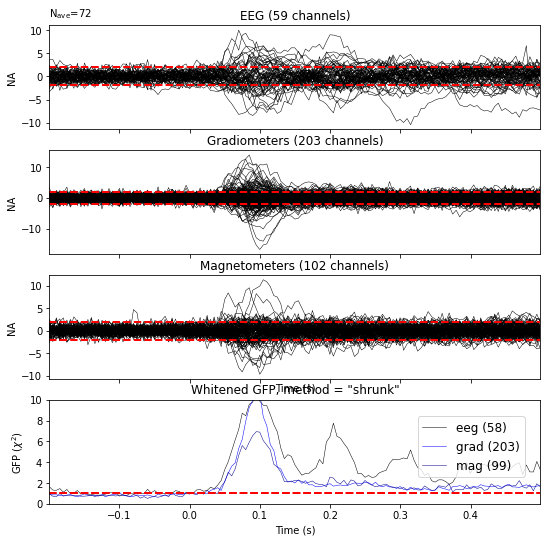

In [12]:
evoked = epochs.average()
evoked.plot_white(noise_cov_reg, time_unit='s', verbose=False);

This plot displays both, the whitened evoked signals for each channels and
the whitened GFP. The numbers in the GFP panel represent the estimated rank
of the data, which amounts to the effective degrees of freedom by which the
squared sum across sensors is divided when computing the whitened GFP.
The whitened GFP also helps detecting spurious late evoked components which
can be the consequence of over- or under-regularization.

Now let's compare two regularization methods

Loading data for 72 events and 421 original time points (prior to decimation) ...
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 305 dim * 5.4e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.8e-11 (2.2e-16 eps * 59 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 2952
log-likelihood on unseen data (descending order):
   shrunk: -1769.853
   empirical: -1797.005
[done]


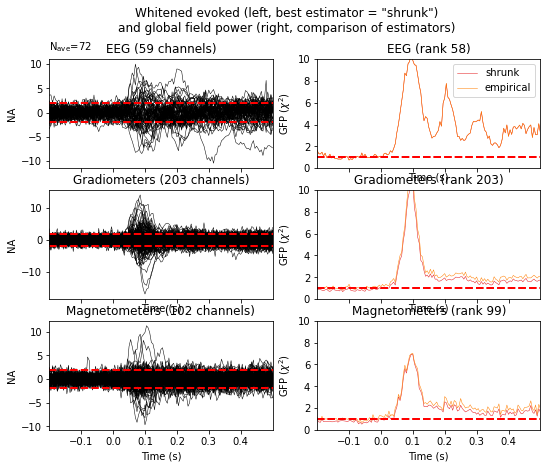

In [13]:
noise_covs = mne.compute_covariance(
    epochs, tmax=0., method=('empirical', 'shrunk'), return_estimators=True,
    rank=None)
evoked.plot_white(noise_covs, time_unit='s', verbose=False);

This will plot the whitened evoked for the optimal estimator and display the
GFPs for all estimators as separate lines in the related panel.



Finally, let's have a look at the difference between empty room and
event related covariance.



Removing projector <Projection | Average EEG reference, active : True, n_channels : 59>


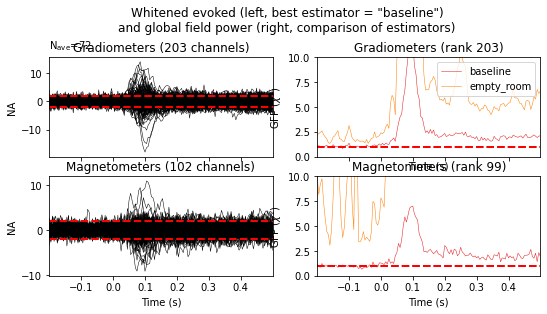

In [14]:
evoked_meg = evoked.copy().pick_types(meg=True, eeg=False)
noise_cov_meg = mne.pick_channels_cov(noise_cov_baseline, evoked_meg.ch_names)
noise_cov['method'] = 'empty_room'
noise_cov_meg['method'] = 'baseline'

evoked_meg.plot_white([noise_cov_meg, noise_cov], time_unit='s', verbose=False);

Based on the negative log likelihood, the baseline covariance seems more appropriate.

References
----------

[1] Engemann D. and Gramfort A. (2015) Automated model selection in
    covariance estimation and spatial whitening of MEG and EEG signals,
    vol. 108, 328-342, NeuroImage.